In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from qmmc import *

## Format data

In [3]:
df = pd.read_csv('/Users/arnaud/cellule/data/bnpp/ETSAnonymousPricesFull.csv')

/Users/arnaud/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (9,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [26]:
idx_done = df["TradeStatus"].values == "Done"
idx_traded_away = df["TradeStatus"].values == "TradedAway"
idx_not_traded = df["TradeStatus"].values == "NotTraded"
df = df[idx_done + idx_traded_away + idx_not_traded]

df["Y"] = (df["BNPPAnsweredQuote"] - df["RFQCompositePrice"]) / np.abs(df["Bid2Mid"])
df = df[df["Y"] < 2]
df = df[df["Y"] > -2]

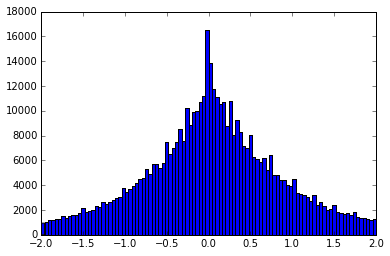

In [27]:
plt.hist(df["Y"].values, bins=100)
plt.show()

In [28]:
n = 1
dd = df[df["NbDealers"] == n + 1]

Y_real = dd["Y"].values

I = dd["TradeStatus"].values
II = np.empty(I.shape[0], dtype=int)
II[I == "Done"] = 2
II[I == "TradedAway"] = 1
II[I == "NotTraded"] = 0
I_real = II

In [29]:
m = 5000
n_samples = Y_real.shape[0]
idx = np.random.randint(0, n_samples, 5000)

In [30]:
Y_real = Y_real[idx]
I_real = I_real[idx]

## Estimate model parameters from data

In [31]:
# Priors
mu_0, sigma_0 = Value(0), Value(10)
scale_0, shape_0 = Value(3), Value(3)
a_0, b_0 = Value(1), Value(2)

# Parameters and variables
mu_V = Normal(mu_0, sigma_0, value=0, name='mu_V')
sigma_V = InvGamma(scale_0, shape_0, value=5, name='sigma_V')
V = Normal(mu_V, sigma_V, size=m, name='V')

Y = Value(Y_real)

mu_W = Normal(mu_0, sigma_0, value=0, name='mu_W')
sigma_W = InvGamma(scale_0, shape_0, value=5, name='sigma_W')
W = Normal(mu_W, sigma_W, size=(m, n), name='W')

@Function
def S(Y=Y, V=V, W=W):
    d = np.empty(Y.shape, dtype=int)
    
    C = np.min(W, axis=1)
    idx_done = Y <= np.minimum(C, V)
    idx_traded_away = C <= np.minimum(Y, V)
    idx_not_traded = V < np.minimum(C, Y)
    
    d[idx_not_traded] = 0
    d[idx_traded_away] = 1
    d[idx_done] = 2
    return d

p = Value(0.0)
I = BernoulliFlip(p, S, k=3, value=I_real, observed=True, name='I')

In [32]:
v_sampler = VSampler(V)
w_sampler = WSampler(W)
pv_sampler = NormalConjugateSampler(mu_V, sigma_V)
pw_sampler = NormalConjugateSampler(mu_W, sigma_W)

In [33]:
model = Model(variables=[mu_V, sigma_V, V, mu_W, sigma_W, W, Y, S, I],
              samplers=[v_sampler, w_sampler, pv_sampler, pw_sampler])

In [34]:
model.samplers

{'V': <qmmc.custom_samplers.VSampler at 0x1309683d0>,
 'W': <qmmc.custom_samplers.WSampler at 0x126b64e10>,
 'mu_V & sigma_V': <qmmc.custom_samplers.NormalConjugateSampler at 0x1287ecfd0>,
 'sigma_W & mu_W': <qmmc.custom_samplers.NormalConjugateSampler at 0x1261e57d0>}

In [35]:
# Check that initial state IS NOT consistent.
print sum(I.value != S.value)

3321


In [36]:
%%time
model.estimate(1000)

0% 1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 28% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 56% 57% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100%
CPU times: user 5min 1s, sys: 601 ms, total: 5min 2s
Wall time: 5min 2s


In [37]:
# Check that final state IS consistent
print sum(I.value != S.value)

0


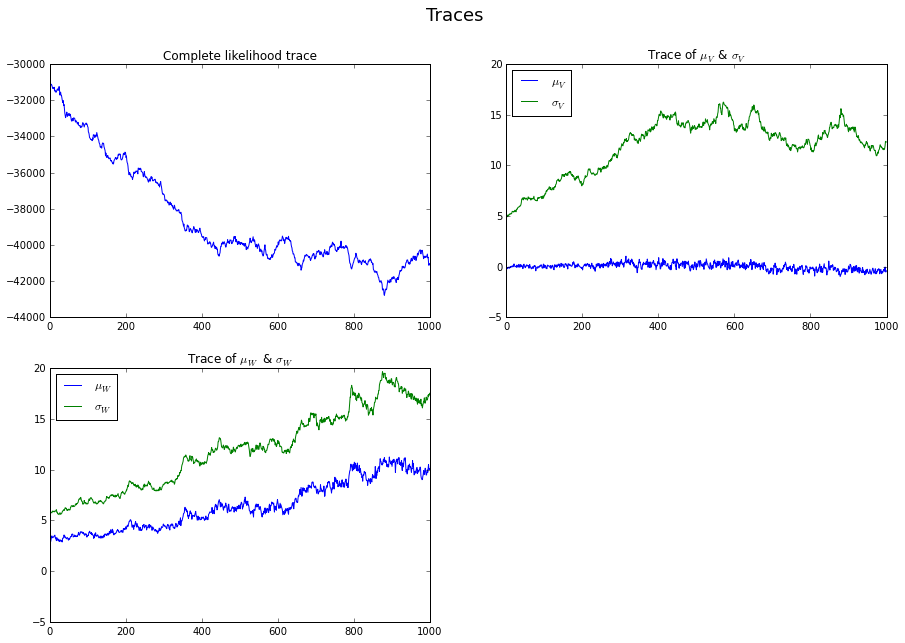

In [38]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(model.logp_history)
plt.title("Complete likelihood trace")

plt.subplot(2, 2, 2)
plt.plot(pv_sampler.history['mu'])
plt.plot(pv_sampler.history['sigma'])
plt.legend([r"$\mu_V$", r"$\sigma_V$"], loc='best')
plt.title(r"Trace of $\mu_V$ & $\sigma_V$")

plt.subplot(2, 2, 3)
plt.plot(pw_sampler.history['mu'])
plt.plot(pw_sampler.history['sigma'])
plt.legend([r"$\mu_W$", r"$\sigma_W$"], loc='best')
plt.title(r"Trace of $\mu_W$ & $\sigma_W$")

plt.suptitle(r"Traces", size=18)
plt.show()